In [1]:
import random
import time
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from collections import Counter
from colour import Color
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocess the data

In [3]:
def get_data_files(language):
    ## REPLACE THIS PATH UPTO dakshina_dataset_v1.0 with your own dataset path ##
    template = "/content/drive/MyDrive/Assignment_3/hi.translit.sampled.{}.tsv"

    train_tsv = template.format("train")
    val_tsv = template.format("dev")
    test_tsv = template.format("test")

    return train_tsv, val_tsv, test_tsv

## Utility functions for preprocessing data ##

def add_start_end_tokens(df, cols, sos="\t", eos="\n"):
    """ Adds EOS and SOS tokens to data
    """
    def add_tokens(s):
        return sos + str(s) + eos

    for col in cols:
        df[col] = df[col].apply(add_tokens)

def tokenize(lang, tokenizer=None):
    """ Uses tf.keras tokenizer to tokenize the data/words into characters
    """

    if tokenizer is None:
        tokenizer = Tokenizer(char_level=True)
        tokenizer.fit_on_texts(lang)

        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,
                                                            padding='post')

    else:
        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,
                                                            padding='post')

    return lang_tensor, tokenizer

def preprocess_data(fpath, input_lang_tokenizer=None, targ_lang_tokenizer=None):
    """ Reads, tokenizes and adds SOS/EOS tokens to data based on above functions
    """

    df = pd.read_csv(fpath, sep="\t", header=None)

    # adding start and end tokens to know when to stop predicting
    add_start_end_tokens(df, [0,1])

    input_lang_tensor, input_tokenizer = tokenize(df[1].astype(str).tolist(),
                                                    tokenizer=input_lang_tokenizer)

    targ_lang_tensor, targ_tokenizer = tokenize(df[0].astype(str).tolist(),
                                                    tokenizer=targ_lang_tokenizer)

    dataset = tf.data.Dataset.from_tensor_slices((input_lang_tensor, targ_lang_tensor))
    dataset = dataset.shuffle(len(dataset))

    return dataset, input_tokenizer, targ_tokenizer

# Build Model

In [4]:
## Utility functions ##
def get_layer(name, units, dropout, return_state=False, return_sequences=False):

    if name=="rnn":
        return layers.SimpleRNN(units=units, dropout=dropout,
                                return_state=return_state,
                                return_sequences=return_sequences)

    if name=="gru":
        return layers.GRU(units=units, dropout=dropout,
                          return_state=return_state,
                          return_sequences=return_sequences)

    if name=="lstm":
        return layers.LSTM(units=units, dropout=dropout,
                           return_state=return_state,
                           return_sequences=return_sequences)

class RNNAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(RNNAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, enc_state, enc_out):

    enc_state = tf.concat(enc_state, 1)
    enc_state = tf.expand_dims(enc_state, 1)

    score = self.V(tf.nn.tanh(self.W1(enc_state) + self.W2(enc_out)))

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * enc_out
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


class Encoder(tf.keras.Model):
    def __init__(self, layer_type, n_layers, units, encoder_vocab_size, embedding_dim, dropout):
        super(Encoder, self).__init__()
        self.layer_type = layer_type
        self.n_layers = n_layers
        self.units = units
        self.dropout = dropout
        self.embedding = tf.keras.layers.Embedding(encoder_vocab_size, embedding_dim)
        self.create_rnn_layers()

    def call(self, x, hidden):
        x = self.embedding(x)
        outputs=x

        if (self.layer_type=='lstm'):
            outputs, h, c = self.rnn_layers[0](outputs, initial_state=hidden)
            state = [h, c]
        else:
            outputs, h = self.rnn_layers[0](outputs, initial_state=hidden)
            state = [h]

        # Remaining LSTM layers just take outputs from previous layer
        for layer in self.rnn_layers[1:]:
            if (self.layer_type=='lstm'):
               outputs, h, c = layer(outputs)
               state = [h, c]  # update state if needed
            else:
               outputs, h = layer(outputs)
               state = [h]

        return outputs, state

    def create_rnn_layers(self):
        self.rnn_layers = []

        for i in range(self.n_layers):
            self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                                return_sequences=True,
                                                return_state=True))


    def initialize_hidden_state(self, batch_size):

        if self.layer_type != "lstm":
            return [tf.zeros((batch_size, self.units))]
        else:
            return [tf.zeros((batch_size, self.units))]*2

class Decoder(tf.keras.Model):
    def __init__(self, layer_type, n_layers, units, decoder_vocab_size, embedding_dim, dropout, attention=False):
        super(Decoder, self).__init__()

        self.layer_type = layer_type
        self.n_layers = n_layers
        self.units = units
        self.dropout = dropout
        self.attention = attention
        self.embedding_layer = layers.Embedding(input_dim=decoder_vocab_size,
                                                output_dim=embedding_dim)

        self.dense = layers.Dense(decoder_vocab_size, activation="softmax")
        self.flatten = layers.Flatten()
        if self.attention:
            self.attention_layer = RNNAttention(self.units)
        self.create_rnn_layers()

    def call(self, x, hidden, enc_out=None):

        x = self.embedding_layer(x)

        if self.attention:
            context_vector, attention_weights = self.attention_layer(hidden, enc_out)
            x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
        else:
            attention_weights = None

        # First LSTM layer gets the initial hidden state
        if (self.layer_type=='lstm'):
            x, h, c = self.rnn_layers[0](x, initial_state=hidden)
            state = [h, c]
        else:
            x, h = self.rnn_layers[0](x, initial_state=hidden)
            state = [h]

        # Subsequent layers use only the output of the previous layer
        for layer in self.rnn_layers[1:]:
            if (self.layer_type=='lstm'):
                x, h, c = layer(x)
                state = [h, c]  # Update state if you want final output from last LSTM
            else:
                x, h = layer(x)
                state = [h]

        output = self.dense(self.flatten(x))

        return output, state, attention_weights

    def create_rnn_layers(self):
        self.rnn_layers = []

        for i in range(self.n_layers - 1):
            self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                                return_sequences=True,
                                                return_state=True))

        self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                            return_sequences=False,
                                            return_state=True))

In [5]:
class BeamSearch():
    def __init__(self, model, k):
        self.k = k
        self.model = model
        self.acc = tf.keras.metrics.Accuracy()

    def sample_beam_search(self, probs):

        m, n = probs.shape
        output_sequences = [[[], 0.0]]

        for row in probs:
            beams = []

            for tup in output_sequences:
                seq, score = tup
                for j in range(n):
                    new_beam = [seq + [j], score - tf.math.log(row[j])]
                    beams.append(new_beam)

            output_sequences = sorted(beams, key=lambda x: x[1])[:self.k]

        tensors, scores = list(zip(*output_sequences))
        tensors = list(map(lambda x: tf.expand_dims(tf.constant(x),0), tensors))

        return tf.concat(tensors, 0), scores

    def beam_accuracy(self, input, target):
        accs = []

        for i in range(self.k):
            self.acc.reset_states()
            self.acc.update_state(target, input[i, :])
            accs.append(self.acc.result())

        return max(accs)

    def step(self, input, target, enc_state):

        batch_acc = 0
        sequences = []

        enc_out, enc_state = self.model.encoder(input, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.model.targ_tokenizer.word_index["\t"]]*self.model.batch_size ,1)

        for t in range(1, target.shape[1]):

            preds, dec_state, _ = self.model.decoder(dec_input, dec_state, enc_out)

            sequences.append(preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        sequences = tf.concat(list(map(lambda x: tf.expand_dims(x, 1), sequences)), axis=1)

        for i in range(target.shape[0]):

            possibilities, scores = self.sample_beam_search(sequences[i, :, :])
            batch_acc += self.beam_accuracy(possibilities, target[i, 1:])

        batch_acc = batch_acc / target.shape[0]

        return 0, batch_acc

    def evaluate(self, test_dataset, batch_size=None, upto=5, use_wandb=False):

        if batch_size is not None:
            self.model.batch_size = batch_size
            test_dataset = test_dataset.batch(batch_size)
        else:
            self.model.batch_size = 1

        test_acc = 0
        enc_state = self.model.encoder.initialize_hidden_state(self.model.batch_size)

        for batch, (input, target) in enumerate(test_dataset.take(upto)):

           _, acc = self.step(input, target, enc_state)
           test_acc += acc

        if use_wandb:
            wandb.log({"test acc (beam search)": test_acc / upto})

        print(f"Test Accuracy on {upto*batch_size} samples: {test_acc / upto:.4f}\n")

    def translate(self, word):

        word = "\t" + word + "\n"
        sequences = []
        result = []

        inputs = self.model.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=self.model.max_input_len,
                                                               padding="post")


        enc_state = self.model.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.model.encoder(inputs, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.model.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, self.model.max_target_len):

            preds, dec_state, _ = self.model.decoder(dec_input, dec_state, enc_out)

            sequences.append(preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        sequences = tf.concat(list(map(lambda x: tf.expand_dims(x, 1), sequences)), axis=1)

        possibilities, scores = self.sample_beam_search(tf.squeeze(sequences, 0))
        output_words = self.model.targ_tokenizer.sequences_to_texts(possibilities.numpy())

        def post_process(word):
            word = word.split(" ")[:-1]
            return "".join([x for x in word])

        output_words = list(map(post_process, output_words))

        return output_words, scores

In [6]:
class Seq2SeqModel():
    def __init__(self, embedding_dim, encoder_layers, decoder_layers, layer_type, units, dropout, attention=False):
        self.embedding_dim = embedding_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.layer_type = layer_type
        self.units = units
        self.dropout = dropout
        self.attention = attention
        self.stats = []
        self.batch_size = 128
        self.use_beam_search = False

    def build(self, loss, optimizer, metric):
        self.loss = loss
        self.optimizer = optimizer
        self.metric = metric

    def set_vocabulary(self, input_tokenizer, targ_tokenizer):
        self.input_tokenizer = input_tokenizer
        self.targ_tokenizer = targ_tokenizer
        self.create_model()

    def create_model(self):

        encoder_vocab_size = len(self.input_tokenizer.word_index) + 1
        decoder_vocab_size = len(self.targ_tokenizer.word_index) + 1

        self.encoder = Encoder(self.layer_type, self.encoder_layers, self.units, encoder_vocab_size,
                               self.embedding_dim, self.dropout)

        self.decoder = Decoder(self.layer_type, self.decoder_layers, self.units, decoder_vocab_size,
                               self.embedding_dim,  self.dropout, self.attention)

    @tf.function
    def train_step(self, input, target, enc_state):

        loss = 0

        with tf.GradientTape() as tape:

            enc_out, enc_state = self.encoder(input, enc_state)

            dec_state = enc_state
            dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

            if random.random() < self.teacher_forcing_ratio:

                for t in range(1, target.shape[1]):

                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)

                    dec_input = tf.expand_dims(target[:,t], 1)

            else:

                for t in range(1, target.shape[1]):

                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)

                    preds = tf.argmax(preds, 1)
                    dec_input = tf.expand_dims(preds, 1)


            batch_loss = loss / target.shape[1]

            variables = self.encoder.variables + self.decoder.variables
            gradients = tape.gradient(loss, variables)

            self.optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss, self.metric.result()

    @tf.function
    def validation_step(self, input, target, enc_state):

        loss = 0

        enc_out, enc_state = self.encoder(input, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

        for t in range(1, target.shape[1]):

            preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
            loss += self.loss(target[:,t], preds)
            self.metric.update_state(target[:,t], preds)

            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        batch_loss = loss / target.shape[1]

        return batch_loss, self.metric.result()


    def fit(self, dataset, val_dataset, batch_size=128, epochs=10, use_wandb=False, teacher_forcing_ratio=1.0):

        self.batch_size = batch_size
        self.teacher_forcing_ratio = teacher_forcing_ratio

        steps_per_epoch = len(dataset) // self.batch_size
        steps_per_epoch_val = len(val_dataset) // self.batch_size

        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        val_dataset = val_dataset.batch(self.batch_size, drop_remainder=True)

        # useful when we need to translate the sentence
        sample_inp, sample_targ = next(iter(dataset))
        self.max_target_len = sample_targ.shape[1]
        self.max_input_len = sample_inp.shape[1]

        template = "\nTrain Loss: {0:.4f} Train Accuracy: {1:.4f} Validation Loss: {2:.4f} Validation Accuracy: {3:.4f}"

        print("-"*100)
        for epoch in range(1, epochs+1):
            print(f"EPOCH {epoch}\n")

            ## Training loop ##
            total_loss = 0
            total_acc = 0
            self.metric.reset_state()

            starting_time = time.time()
            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            for batch, (input, target) in enumerate(dataset.take(steps_per_epoch)):
                batch_loss, acc = self.train_step(input, target, enc_state)
                total_loss += batch_loss
                total_acc += acc


                if batch==0 or ((batch + 1) % 100 == 0):
                    print(f"Batch {batch+1} Loss {batch_loss:.4f}")

            avg_acc = total_acc / steps_per_epoch
            avg_loss = total_loss / steps_per_epoch

            # Validation loop ##
            total_val_loss = 0
            total_val_acc = 0
            self.metric.reset_state()

            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            for batch, (input, target) in enumerate(val_dataset.take(steps_per_epoch_val)):
                batch_loss, acc = self.validation_step(input, target, enc_state)
                total_val_loss += batch_loss
                total_val_acc += acc

            avg_val_acc = total_val_acc / steps_per_epoch_val
            avg_val_loss = total_val_loss / steps_per_epoch_val

            print(template.format(avg_loss, avg_acc*100, avg_val_loss, avg_val_acc*100))

            time_taken = time.time() - starting_time
            self.stats.append({"epoch": epoch,
                            "train loss": avg_loss,
                            "val loss": avg_val_loss,
                            "train acc": avg_acc*100,
                            "val acc": avg_val_acc*100,
                            "training time": time_taken})

            if use_wandb:
                wandb.log(self.stats[-1])

            print(f"\nTime taken for the epoch {time_taken:.4f}")

        print("\nModel trained !!")

    def evaluate(self, test_dataset, batch_size=None):

        if batch_size is not None:
            self.batch_size = batch_size

        steps_per_epoch_test = len(test_dataset) // batch_size
        test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

        total_test_loss = 0
        total_test_acc = 0
        self.metric.reset_state()

        enc_state = self.encoder.initialize_hidden_state(self.batch_size)

        for batch, (input, target) in enumerate(test_dataset.take(steps_per_epoch_test)):
            batch_loss, acc = self.validation_step(input, target, enc_state)
            total_test_loss += batch_loss
            total_test_acc += acc

        avg_test_acc = total_test_acc / steps_per_epoch_test
        avg_test_loss = total_test_loss / steps_per_epoch_test

        print(f"Test Loss: {avg_test_loss:.4f} Test Accuracy: {avg_test_acc:.4f}")

        return avg_test_loss, avg_test_acc


    def translate(self, word, get_heatmap=False):

        word = "\t" + word + "\n"

        inputs = self.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=self.max_input_len,
                                                               padding="post")

        result = ""
        att_wts = []

        enc_state = self.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.encoder(inputs, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, self.max_target_len):

            preds, dec_state, attention_weights = self.decoder(dec_input, dec_state, enc_out)

            if get_heatmap:
                att_wts.append(attention_weights)

            preds = tf.argmax(preds, 1)
            next_char = self.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char

            dec_input = tf.expand_dims(preds, 1)

            if next_char == "\n":
                return result[:-1], att_wts[:-1]

        return result[:-1], att_wts[:-1]

    def plot_attention_heatmap(self, word, ax, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):

        translated_word, attn_wts = self.translate(word, get_heatmap=True)
        attn_heatmap = tf.squeeze(tf.concat(attn_wts, 0), -1).numpy()

        input_word_len = len(word)
        output_word_len = len(translated_word)

        ax.imshow(attn_heatmap[:, :input_word_len])

        font_prop = FontProperties(fname=font_path, size=18)

        ax.set_xticks(np.arange(input_word_len))
        ax.set_yticks(np.arange(output_word_len))

        ax.set_xticklabels(list(word))
        ax.set_yticklabels(list(translated_word), fontproperties=font_prop)


In [7]:
def randomly_evaluate(model, test_file=get_data_files("hi")[2], n=10):

    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    print(f"Randomly evaluating the model on {n} words\n")

    for i in range(n):
        word = str(df[1][i])

        print(f"Input word: {word}")
        print(f"Actual translation: {str(df[0][i])}")
        print(f"Model translation: {model.translate(word)[0]}\n")


def test_on_dataset(language, embedding_dim, encoder_layers, decoder_layers, layer_type, units, dropout, attention, teacher_forcing_ratio=1.0, filename=None):

    TRAIN_TSV, VAL_TSV, TEST_TSV = get_data_files(language)

    model = Seq2SeqModel(embedding_dim,
                         encoder_layers,
                         decoder_layers,
                         layer_type,
                         units,
                         dropout,
                         attention)

    dataset, input_tokenizer, targ_tokenizer = preprocess_data(TRAIN_TSV)
    val_dataset, _, _ = preprocess_data(VAL_TSV, input_tokenizer, targ_tokenizer)

    model.set_vocabulary(input_tokenizer, targ_tokenizer)
    model.build(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metric = tf.keras.metrics.SparseCategoricalAccuracy())

    model.fit(dataset, val_dataset, epochs=30, use_wandb=False, teacher_forcing_ratio=teacher_forcing_ratio)

    ## Character level accuracy ##
    test_dataset, _, _ = preprocess_data(TEST_TSV, model.input_tokenizer, model.targ_tokenizer)
    test_loss, test_acc = model.evaluate(test_dataset, batch_size=100)

    ##  Word level accuracy ##
    test_tsv = pd.read_csv(TEST_TSV, sep="\t", header=None)
    inputs = test_tsv[1].astype(str).tolist()
    targets = test_tsv[0].astype(str).tolist()

    outputs = []

    for word in inputs:
        outputs.append(model.translate(word)[0])

    if filename is not None:
        df = pd.DataFrame()
        df["inputs"] = inputs
        df["targets"] = targets
        df["outputs"] = outputs
        df.to_csv(filename)


    return model


# Visualizing Model Connectivity (Q6)

In [8]:
# Tools for getting model connectivity between input and output characters

def get_lstm_output(decoder, x, hidden, enc_out=None):
    x = decoder.embedding_layer(x)

    if decoder.attention:
        context_vector, attention_weights = decoder.attention_layer(hidden, enc_out)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
    else:
        attention_weights = None

    # First layer with initial state
    x, h, c = decoder.rnn_layers[0](x, initial_state=hidden)
    state = [h, c]

    # Remaining layers
    for layer in decoder.rnn_layers[1:]:
        x, h, c = layer(x)
        state = [h, c]  # keep the last layer's state

    return x, state, attention_weights

def get_output_from_embedding(encoder, x, hidden):
    x, h, c = encoder.rnn_layers[0](x, initial_state=hidden)
    state = [h, c]

    for layer in encoder.rnn_layers[1:]:
        x, h, c = layer(x)
        state = [h, c]

    return x, state


def get_connectivity(model, word):

    word = "\t" + word + "\n"

    inputs = model.input_tokenizer.texts_to_sequences([word])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                            maxlen=model.max_input_len,
                                                            padding="post")

    result = ""

    gradient_list = []

    enc_state = model.encoder.initialize_hidden_state(1)
    embedded_in = model.encoder.embedding(inputs)


    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
        tape.watch(embedded_in)

        enc_out, enc_state = get_output_from_embedding(model.encoder, embedded_in, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([model.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, model.max_target_len):

            lstm_out, dec_state, _ = get_lstm_output(model.decoder, dec_input, dec_state, enc_out)

            preds = model.decoder.dense(model.decoder.flatten(lstm_out))
            gradient_list.append(tape.gradient(lstm_out, embedded_in)[0])

            preds = tf.argmax(preds, 1)
            next_char = model.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char

            dec_input = tf.expand_dims(preds, 1)

            if next_char == "\n":
                return result[:-1], gradient_list[:-1]

        return result[:-1], gradient_list[:-1]


In [9]:
# Imports for visualising the model connectivity
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint

from IPython.display import HTML as html_print
from IPython.display import display
import tensorflow.keras.backend as K

# get html element
def cstr(s, color='black'):
    if s == ' ':
      return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
    else:
      return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)

# print html
def print_color(t):
	  display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
    colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
      '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
      '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
      '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
    value = int(value * 19)
    if value == 19:
        value -= 1
    return colors[value]

# sigmoid function
def sigmoid(x):
    z = 1/(1 + np.exp(-x))
    return z

def softmax(x):
    v = np.exp(x)
    v = v / np.sum(v)
    return v

def get_gradient_norms(grad_list, word, activation="sigmoid"):
    grad_norms = []
    for grad_tensor in grad_list:
        grad_mags = tf.norm(grad_tensor, axis=1)
        grad_mags = grad_mags[:len(word)]
        if activation == "softmax":
            grad_mags_scaled = softmax(grad_mags)
        elif activation == "scaler":
            scaler = MinMaxScaler()
            grad_mags = tf.reshape(grad_mags, (-1,1))
            grad_mags_scaled = scaler.fit_transform(grad_mags)
        else:
            grad_mags_scaled = sigmoid(grad_mags)
        grad_norms.append(grad_mags_scaled)
    return grad_norms

def visualize(grad_norms, word, translated_word):
    print("Original Word:", word)
    print("Transliterated Word:", translated_word)
    for i in range(len(translated_word)):
        print("Connectivity Visualization for", translated_word[i],":")
        text_colours = []
        for j in range(len(grad_norms[i])):
            text = (word[j], get_clr(grad_norms[i][j]))
            text_colours.append(text)
        print_color(text_colours)

def visualise_connectivity(model, word, activation="sigmoid"):
    translated_word, grad_list = get_connectivity(model, word)
    grad_norms = get_gradient_norms(grad_list, word, activation)
    visualize(grad_norms, word, translated_word)

In [ ]:
model = test_on_dataset(language="hi",
                        embedding_dim=256,
                        encoder_layers=3,
                        decoder_layers=3,
                        layer_type="lstm",
                        units=256,
                        dropout=0.2,
                        attention=True,
                        filename="English_To_Hindi_with_Attention.csv")

In [ ]:
def get_test_words(n):
    test_df = pd.read_csv(get_data_files("hi")[2])
    test_sample = test_df.sample(n)
    test_sample.reset_index(inplace=True, drop=True)
    test_words = []
    for i in test_sample.index:
        entry = test_sample["अंक\tank\t5"].loc[i]
        parts = entry.split("\t")
        word = parts[1]
        test_words.append(word)
    return test_words

test_words = get_test_words(5)
print(test_words)

['hisham', 'vadiyon', 'robertsan', 'bheed', 'denewaali']


In [ ]:
for word in test_words:
    visualise_connectivity(model, word, activation="scaler")

Calling LSTM with: <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 22, 256)
Hidden is: <class 'list'> [TensorShape([1, 256]), TensorShape([1, 256])]
Original Word: hisham
Transliterated Word: हिशम
Connectivity Visualization for ह :


<ipython-input-10-abcb4f2a6bda>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Connectivity Visualization for ि :


Connectivity Visualization for श :


Connectivity Visualization for म :


Calling LSTM with: <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 22, 256)
Hidden is: <class 'list'> [TensorShape([1, 256]), TensorShape([1, 256])]
Original Word: vadiyon
Transliterated Word: वाडियों
Connectivity Visualization for व :


<ipython-input-10-abcb4f2a6bda>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Connectivity Visualization for ा :


Connectivity Visualization for ड :


Connectivity Visualization for ि :


Connectivity Visualization for य :


Connectivity Visualization for ो :


Connectivity Visualization for ं :


Calling LSTM with: <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 22, 256)
Hidden is: <class 'list'> [TensorShape([1, 256]), TensorShape([1, 256])]
Original Word: robertsan
Transliterated Word: रोबर्ट्सन
Connectivity Visualization for र :


<ipython-input-10-abcb4f2a6bda>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Connectivity Visualization for ो :


Connectivity Visualization for ब :


Connectivity Visualization for र :


Connectivity Visualization for ् :


Connectivity Visualization for ट :


Connectivity Visualization for ् :


Connectivity Visualization for स :


Connectivity Visualization for न :


Calling LSTM with: <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 22, 256)
Hidden is: <class 'list'> [TensorShape([1, 256]), TensorShape([1, 256])]
Original Word: bheed
Transliterated Word: भीड़
Connectivity Visualization for भ :


<ipython-input-10-abcb4f2a6bda>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Connectivity Visualization for ी :


Connectivity Visualization for ड :


Connectivity Visualization for ़ :


Calling LSTM with: <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 22, 256)
Hidden is: <class 'list'> [TensorShape([1, 256]), TensorShape([1, 256])]
Original Word: denewaali
Transliterated Word: देनेवाली
Connectivity Visualization for द :


<ipython-input-10-abcb4f2a6bda>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Connectivity Visualization for े :


Connectivity Visualization for न :


Connectivity Visualization for े :


Connectivity Visualization for व :


Connectivity Visualization for ा :


Connectivity Visualization for ल :


Connectivity Visualization for ी :


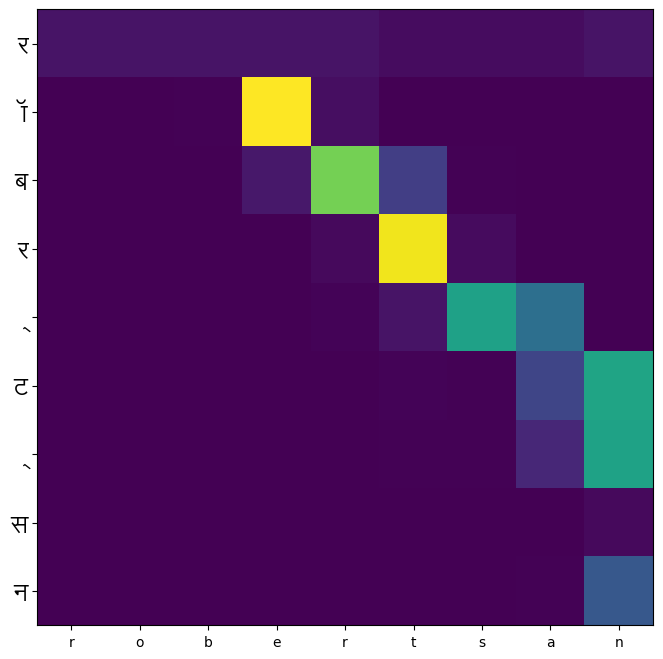

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
model.plot_attention_heatmap('robertsan', ax)

In [ ]:
randomly_evaluate(model, n=20)

Randomly evaluating the model on 20 words

Input word: piky
Actual translation: पिकी
Model translation: पिकी

Input word: wipro
Actual translation: विप्रो
Model translation: विप्रो

Input word: chhupata
Actual translation: छुपता
Model translation: छुपता

Input word: jassi
Actual translation: जस्सी
Model translation: जस्सी

Input word: tahkhana
Actual translation: तहखाना
Model translation: तहखाना

Input word: cube
Actual translation: क्यूब
Model translation: कब

Input word: tel
Actual translation: तेल
Model translation: टेल

Input word: jaydayal
Actual translation: जयदयाल
Model translation: जायदायल

Input word: sabah
Actual translation: साबाह
Model translation: सबाह

Input word: kihatkati
Actual translation: खटकती
Model translation: किहतकति

Input word: bakayon
Actual translation: बकायों
Model translation: बकायों

Input word: andrabi
Actual translation: अंद्राबी
Model translation: अंदराबी

Input word: fagua
Actual translation: फगुआ
Model translation: फगुआ

Input word: chowk
Actual trans

# WandB Function

In [10]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alokgaurav04 (alokgaurav04-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [11]:
def train_with_wandb(language, test_beam_search=False):

    config_defaults = {"embedding_dim": 64,
                       "enc_dec_layers": 1,
                       "layer_type": "lstm",
                       "units": 128,
                       "dropout": 0,
                       "attention": False,
                       "beam_width": 3,
                       "teacher_forcing_ratio": 1.0
                       }

    wandb.init(config=config_defaults, project="DA6401_Assignment_3", resume=True)

    ## 1. SELECT LANGUAGE ##
    TRAIN_TSV, VAL_TSV, TEST_TSV = get_data_files(language)

    ## 2. DATA PREPROCESSING ##
    dataset, input_tokenizer, targ_tokenizer = preprocess_data(TRAIN_TSV)
    val_dataset, _, _ = preprocess_data(VAL_TSV, input_tokenizer, targ_tokenizer)

    ## 3. CREATING THE MODEL ##
    model = Seq2SeqModel(embedding_dim=wandb.config.embedding_dim,
                         encoder_layers=wandb.config.enc_dec_layers,
                         decoder_layers=wandb.config.enc_dec_layers,
                         layer_type=wandb.config.layer_type,
                         units=wandb.config.units,
                         dropout=wandb.config.dropout,
                         attention=wandb.config.attention)

    ## 4. COMPILING THE MODEL
    model.set_vocabulary(input_tokenizer, targ_tokenizer)
    model.build(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metric = tf.keras.metrics.SparseCategoricalAccuracy())

    ## 5. FITTING AND VALIDATING THE MODEL
    model.fit(dataset, val_dataset, epochs=10, use_wandb=True, teacher_forcing_ratio=wandb.config.teacher_forcing_ratio)

    if test_beam_search:
        ## OPTIONAL :- Evaluate the dataset using beam search and without beam search
        val_dataset, _, _ = preprocess_data(VAL_TSV, model.input_tokenizer, model.targ_tokenizer)
        subset = val_dataset.take(500)

        # a) Without beam search
        _, test_acc_without = model.evaluate(subset, batch_size=100)
        wandb.log({"test acc": test_acc_without})

        # b) With beam search
        beam_search = BeamSearch(model=model, k=wandb.config.beam_width)
        beam_search.evaluate(subset, batch_size=100, use_wandb=True)

# Sweeps without Attention

In [ ]:
sweep_config = {
  "method": "grid",
  "metric":{
      'name':'val acc',
      'goal':'maximize'
  },
  "parameters": {
        "enc_dec_layers": {
           "values": [1, 2, 3]                 # Number of Encoder and Decoder layer
        },
        "units": {
            "values": [64, 128, 256]           # Dimensionality
        },
        "layer_type": {
            "values": ["rnn", "gru", "lstm"]   # Cell Type
        },
        "embedding_dim": {
            "values": [64, 128, 256]           #Embedding size
        },
        "dropout": {
            "values": [0.2, 0.3]               #Dropout
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment_3")

Create sweep with ID: umh6hves
Sweep URL: https://wandb.ai/alokgaurav04-indian-institute-of-technology-madras/DA6401_Assignment_3/sweeps/umh6hves


In [ ]:
wandb.agent(sweep_id, function=lambda: train_with_wandb("hi"))

In [ ]:
sweep_config3 = {
  "name": "Sweep 3- Assignment3",
  "method": "grid",
  "metric":{
      'name':'val acc',
      'goal':'maximize'
  },
  "parameters": {

        "beam_width": {
            "values": [3, 5, 7]
        }
    }
}

In [ ]:
sweep_id3 = wandb.sweep(sweep_config3, project="DA6401_Assignment_3")

Create sweep with ID: k43xn9pq
Sweep URL: https://wandb.ai/alokgaurav04-indian-institute-of-technology-madras/DA6401_Assignment_3/sweeps/k43xn9pq


In [ ]:
wandb.agent(sweep_id3, function=lambda: train_with_wandb("hi", test_beam_search=True))

# Sweeps with Attention

In [13]:
sweep_config4 = {
  "name": "Sweep Attention",
  "method": "grid",
  "metric":{
      'name':'val acc',
      'goal':'maximize'
  },
  "parameters": {
        "enc_dec_layers": {
           "values": [1, 2, 3]
        },
        "units": {
            "values": [128, 256]
        },
        "dropout": {
            "values": [0, 0.2]
        },
        "attention": {
            "values": [True]
        }
    }
}

In [14]:
sweep_id4 = wandb.sweep(sweep_config4, project="DA6401_Assignment_3")

Create sweep with ID: 691yfjl7
Sweep URL: https://wandb.ai/alokgaurav04-indian-institute-of-technology-madras/DA6401_Assignment_3/sweeps/691yfjl7


In [15]:
wandb.agent(sweep_id4, function=lambda: train_with_wandb("hi"), project="DA6401_Assignment_3")

wandb: Agent Starting Run: xr2bqdyn with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 1
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9904
Batch 100 Loss 1.0334
Batch 200 Loss 0.9856
Batch 300 Loss 0.9373

Validating ...

Train Loss: 1.0794 Train Accuracy: 68.2295 Validation Loss: 1.9414 Validation Accuracy: 53.9737

Time taken for the epoch 37.5776
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.8995
Batch 100 Loss 0.9445
Batch 200 Loss 0.8068
Batch 300 Loss 0.6582

Validating ...

Train Loss: 0.8070 Train Accuracy: 75.2459 Validation Loss: 1.9383 Validation Accuracy: 56.8561

Time taken for the epoch 14.1430
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.6576
Batch 100 Loss 0.5533
Batch 200 Loss 0.4891
Batch 300 Loss 0.3808

Validating ...

Train Loss: 0.5248 Train Accuracy: 81.6972 Validation Loss: 1.4740 Validation Accuracy: 70.4962

Time taken for the epoch 14.4757
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▄▇▇█████
train loss,█▆▄▂▂▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▂▅▆▇▇████
val loss,██▄▄▁▂▁▁▁▁
epoch,10
train acc,95.37332
train loss,0.1385
training time,15.08459
val acc,82.88126


wandb: Agent Starting Run: 95pskfmj with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 1
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9832
Batch 100 Loss 1.0314
Batch 200 Loss 0.9649
Batch 300 Loss 0.8532

Validating ...

Train Loss: 1.0457 Train Accuracy: 68.5121 Validation Loss: 2.5884 Validation Accuracy: 46.2608

Time taken for the epoch 40.4929
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.8951
Batch 100 Loss 0.8375
Batch 200 Loss 0.7163
Batch 300 Loss 0.7093

Validating ...

Train Loss: 0.7802 Train Accuracy: 75.7276 Validation Loss: 2.3865 Validation Accuracy: 53.4320

Time taken for the epoch 21.8126
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.6199
Batch 100 Loss 0.5598
Batch 200 Loss 0.5255
Batch 300 Loss 0.4494

Validating ...

Train Loss: 0.5256 Train Accuracy: 82.0221 Validation Loss: 1.7944 Validation Accuracy: 65.4901

Time taken for the epoch 21.4828
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▄▆▇▇████
train loss,█▆▄▃▂▂▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▂▅▆▇▇▇███
val loss,█▇▄▂▂▁▁▁▁▁
epoch,10
train acc,96.48083
train loss,0.1083
training time,21.49943
val acc,82.85252


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jtuck3vw with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 2
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9902
Batch 100 Loss 1.1465
Batch 200 Loss 0.9604
Batch 300 Loss 1.0043

Validating ...

Train Loss: 1.2269 Train Accuracy: 65.8721 Validation Loss: 1.8301 Validation Accuracy: 58.3261

Time taken for the epoch 45.3325
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9415
Batch 100 Loss 0.9230
Batch 200 Loss 0.9316
Batch 300 Loss 0.8767

Validating ...

Train Loss: 0.9381 Train Accuracy: 72.7942 Validation Loss: 2.1948 Validation Accuracy: 52.5495

Time taken for the epoch 18.6182
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.8825
Batch 100 Loss 0.9449
Batch 200 Loss 0.8799
Batch 300 Loss 0.8782

Validating ...

Train Loss: 0.8878 Train Accuracy: 74.0083 Validation Loss: 2.2061 Validation Accuracy: 53.5198

Time taken for the epoch 20.0677
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▃▃▄▅▆▇██
train loss,█▆▆▅▄▃▂▂▁▁
training time,█▁▁▁▁▁▁▁▁▂
val acc,▂▁▁▁▃▅▇▇██
val loss,▄▇▇█▅▄▂▂▁▁
epoch,10
train acc,93.36434
train loss,0.21297
training time,20.89827
val acc,80.78865


wandb: Agent Starting Run: cfkb4mvl with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 2
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9901
Batch 100 Loss 1.0446
Batch 200 Loss 0.9648
Batch 300 Loss 0.9677

Validating ...

Train Loss: 1.1418 Train Accuracy: 66.9102 Validation Loss: 2.1940 Validation Accuracy: 56.8442

Time taken for the epoch 53.3451
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9459
Batch 100 Loss 0.9256
Batch 200 Loss 0.9123
Batch 300 Loss 0.8855

Validating ...

Train Loss: 0.9242 Train Accuracy: 72.9054 Validation Loss: 2.3170 Validation Accuracy: 52.5104

Time taken for the epoch 27.5894
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.8649
Batch 100 Loss 0.8739
Batch 200 Loss 0.8743
Batch 300 Loss 0.8516

Validating ...

Train Loss: 0.8478 Train Accuracy: 74.8677 Validation Loss: 2.2169 Validation Accuracy: 55.7763

Time taken for the epoch 27.4429
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▃▄▅▇▇███
train loss,█▆▆▅▄▂▂▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▂▁▂▃▅▇████
val loss,▇█▇▇▄▂▂▂▂▁
epoch,10
train acc,94.69659
train loss,0.15845
training time,27.27465
val acc,82.55457


wandb: Agent Starting Run: 6yx73284 with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 3
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state', 'seed_generator_4/seed_generator_state', 'seed_generator_5/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9903
Batch 100 Loss 1.2170
Batch 200 Loss 1.0958
Batch 300 Loss 1.0074

Validating ...

Train Loss: 1.3213 Train Accuracy: 64.6841 Validation Loss: 2.1843 Validation Accuracy: 56.6602

Time taken for the epoch 58.3336
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0106
Batch 100 Loss 0.9812
Batch 200 Loss 1.0091
Batch 300 Loss 0.9504

Validating ...

Train Loss: 0.9904 Train Accuracy: 71.5816 Validation Loss: 2.1062 Validation Accuracy: 58.3431

Time taken for the epoch 24.7585
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9091
Batch 100 Loss 0.9504
Batch 200 Loss 0.9200
Batch 300 Loss 0.9308

Validating ...

Train Loss: 0.9337 Train Accuracy: 72.6939 Validation Loss: 2.2690 Validation Accuracy: 52.2041

Time taken for the epoch 25.2791
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▄▄▅▅▆▆▇█
train loss,█▅▅▄▄▃▃▂▂▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▄▅▃▁▄▄▄▆▇█
val loss,▂▂▃█▄▆▆▃▂▁
epoch,10
train acc,84.0036
train loss,0.5007
training time,24.54906
val acc,66.06927


wandb: Agent Starting Run: bt1bw46f with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 3
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state', 'seed_generator_4/seed_generator_state', 'seed_generator_5/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9901
Batch 100 Loss 1.1922
Batch 200 Loss 0.9993
Batch 300 Loss 0.9631

Validating ...

Train Loss: 1.2210 Train Accuracy: 65.5381 Validation Loss: 2.6421 Validation Accuracy: 56.9297

Time taken for the epoch 68.0251
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9742
Batch 100 Loss 0.9369
Batch 200 Loss 0.9894
Batch 300 Loss 0.9513

Validating ...

Train Loss: 0.9746 Train Accuracy: 72.0945 Validation Loss: 2.4507 Validation Accuracy: 56.2173

Time taken for the epoch 33.2382
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9513
Batch 100 Loss 0.9427
Batch 200 Loss 0.9317
Batch 300 Loss 0.9362

Validating ...

Train Loss: 0.9551 Train Accuracy: 72.6987 Validation Loss: 2.7221 Validation Accuracy: 48.6244

Time taken for the epoch 33.6260
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▄▄▄▄▅▆▇█
train loss,█▆▆▆▅▅▄▃▂▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▄▄▂▁▄▁▄▅▆█
val loss,▅▄▅█▄█▄▄▃▁
epoch,10
train acc,85.26593
train loss,0.43986
training time,33.88072
val acc,71.58176


wandb: Agent Starting Run: fhueo72d with config:
wandb: 	attention: True
wandb: 	dropout: 0.2
wandb: 	enc_dec_layers: 1
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9850
Batch 100 Loss 1.0654
Batch 200 Loss 1.0271
Batch 300 Loss 0.9410

Validating ...

Train Loss: 1.0939 Train Accuracy: 68.0157 Validation Loss: 2.2856 Validation Accuracy: 48.6540

Time taken for the epoch 38.6951
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9148
Batch 100 Loss 0.8593
Batch 200 Loss 0.8590
Batch 300 Loss 0.7603

Validating ...

Train Loss: 0.8347 Train Accuracy: 74.8832 Validation Loss: 2.0361 Validation Accuracy: 55.1882

Time taken for the epoch 17.3255
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.7468
Batch 100 Loss 0.6327
Batch 200 Loss 0.5139
Batch 300 Loss 0.4593

Validating ...

Train Loss: 0.5503 Train Accuracy: 80.8551 Validation Loss: 1.3813 Validation Accuracy: 72.4558

Time taken for the epoch 15.9940
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▄▇▇█████
train loss,█▆▄▂▂▁▁▁▁▁
training time,█▂▁▁▁▁▁▂▁▁
val acc,▁▂▆▇▇▇████
val loss,█▆▂▂▁▁▁▁▁▁
epoch,10
train acc,94.56509
train loss,0.16079
training time,16.10859
val acc,81.11031


wandb: Agent Starting Run: 7ddgaz3v with config:
wandb: 	attention: True
wandb: 	dropout: 0.2
wandb: 	enc_dec_layers: 1
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9862
Batch 100 Loss 1.0537
Batch 200 Loss 0.9540
Batch 300 Loss 0.9048

Validating ...

Train Loss: 1.0543 Train Accuracy: 68.5014 Validation Loss: 2.8224 Validation Accuracy: 44.5469

Time taken for the epoch 42.6124
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9495
Batch 100 Loss 0.8628
Batch 200 Loss 0.7938
Batch 300 Loss 0.7595

Validating ...

Train Loss: 0.8065 Train Accuracy: 75.4733 Validation Loss: 2.1360 Validation Accuracy: 55.7256

Time taken for the epoch 22.5422
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.6803
Batch 100 Loss 0.6377
Batch 200 Loss 0.5980
Batch 300 Loss 0.5827

Validating ...

Train Loss: 0.6173 Train Accuracy: 79.8480 Validation Loss: 2.0623 Validation Accuracy: 60.7089

Time taken for the epoch 22.1450
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▄▅▆▇████
train loss,█▆▅▃▂▂▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▃▄▅▇▇████
val loss,█▅▅▃▂▁▁▁▁▁
epoch,10
train acc,95.67312
train loss,0.12968
training time,22.40085
val acc,82.87256


wandb: Agent Starting Run: sdofc0f4 with config:
wandb: 	attention: True
wandb: 	dropout: 0.2
wandb: 	enc_dec_layers: 2
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9904
Batch 100 Loss 1.0696
Batch 200 Loss 1.0302
Batch 300 Loss 1.0347

Validating ...

Train Loss: 1.2400 Train Accuracy: 65.8304 Validation Loss: 2.3416 Validation Accuracy: 56.9141

Time taken for the epoch 52.6595
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9576
Batch 100 Loss 0.9599
Batch 200 Loss 0.9737
Batch 300 Loss 0.9131

Validating ...

Train Loss: 0.9725 Train Accuracy: 71.8226 Validation Loss: 2.2339 Validation Accuracy: 53.3786

Time taken for the epoch 22.4677
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9093
Batch 100 Loss 0.9447
Batch 200 Loss 0.9085
Batch 300 Loss 0.9280

Validating ...

Train Loss: 0.9175 Train Accuracy: 73.6079 Validation Loss: 2.3295 Validation Accuracy: 52.7876

Time taken for the epoch 21.8022
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▃▄▄▅▆▇▇█
train loss,█▆▆▅▅▄▃▂▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▂▁▁▂▂▃▅▆▇█
val loss,█▇█▇▇▅▄▃▂▁
epoch,10
train acc,89.68827
train loss,0.315
training time,23.51565
val acc,77.09041


wandb: Agent Starting Run: 1ko1dgnu with config:
wandb: 	attention: True
wandb: 	dropout: 0.2
wandb: 	enc_dec_layers: 2
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9896
Batch 100 Loss 1.1167
Batch 200 Loss 1.0151
Batch 300 Loss 1.0402

Validating ...

Train Loss: 1.1523 Train Accuracy: 67.1780 Validation Loss: 2.4376 Validation Accuracy: 56.1876

Time taken for the epoch 59.1593
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0543
Batch 100 Loss 1.0025
Batch 200 Loss 0.9007
Batch 300 Loss 0.9683

Validating ...

Train Loss: 0.9391 Train Accuracy: 72.6204 Validation Loss: 2.3409 Validation Accuracy: 52.7784

Time taken for the epoch 28.8436
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9293
Batch 100 Loss 0.8513
Batch 200 Loss 0.8638
Batch 300 Loss 0.8179

Validating ...

Train Loss: 0.8603 Train Accuracy: 74.3912 Validation Loss: 2.0955 Validation Accuracy: 57.3953

Time taken for the epoch 41.8518
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▂▃▄▅▆▇███
train loss,█▆▆▅▄▃▂▁▁▁
training time,█▁▄▁▁▁▁▁▁▁
val acc,▂▁▂▄▅▆▇▇██
val loss,█▇▆▄▄▂▁▁▁▁
epoch,10
train acc,93.46329
train loss,0.19496
training time,29.63102
val acc,80.42148


wandb: Agent Starting Run: obmtxlku with config:
wandb: 	attention: True
wandb: 	dropout: 0.2
wandb: 	enc_dec_layers: 3
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state', 'seed_generator_4/seed_generator_state', 'seed_generator_5/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9901
Batch 100 Loss 1.2571
Batch 200 Loss 1.1683
Batch 300 Loss 1.0976

Validating ...

Train Loss: 1.3543 Train Accuracy: 64.0846 Validation Loss: 2.4348 Validation Accuracy: 56.4790

Time taken for the epoch 73.7232
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0840
Batch 100 Loss 0.9880
Batch 200 Loss 0.9794
Batch 300 Loss 1.0261

Validating ...

Train Loss: 1.0050 Train Accuracy: 71.3672 Validation Loss: 2.5526 Validation Accuracy: 56.7310

Time taken for the epoch 30.7541
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9742
Batch 100 Loss 0.9861
Batch 200 Loss 0.8606
Batch 300 Loss 0.8402

Validating ...

Train Loss: 0.9337 Train Accuracy: 72.6450 Validation Loss: 2.0758 Validation Accuracy: 57.2484

Time taken for the epoch 31.5356
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▅▆▇▇▇███
train loss,█▄▃▃▂▂▂▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▆▇▇▃▁▃▆██▅
val loss,▆█▁▅█▆▃▂▂▆
epoch,10
train acc,78.27227
train loss,0.72384
training time,31.66145
val acc,55.1188


wandb: Agent Starting Run: 310k3uat with config:
wandb: 	attention: True
wandb: 	dropout: 0.2
wandb: 	enc_dec_layers: 3
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state', 'seed_generator_4/seed_generator_state', 'seed_generator_5/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9901
Batch 100 Loss 1.2173
Batch 200 Loss 1.0161
Batch 300 Loss 1.0019

Validating ...

Train Loss: 1.2404 Train Accuracy: 65.1121 Validation Loss: 2.5395 Validation Accuracy: 56.5216

Time taken for the epoch 76.5159
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0099
Batch 100 Loss 1.0116
Batch 200 Loss 0.9842
Batch 300 Loss 1.0069

Validating ...

Train Loss: 0.9870 Train Accuracy: 71.5982 Validation Loss: 2.5902 Validation Accuracy: 53.9749

Time taken for the epoch 36.4652
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9605
Batch 100 Loss 1.0289
Batch 200 Loss 0.9536
Batch 300 Loss 0.9131

Validating ...

Train Loss: 0.9669 Train Accuracy: 72.3644 Validation Loss: 2.8053 Validation Accuracy: 48.9030

Time taken for the epoch 37.0005
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▃▃▄▅▅▆▇█
train loss,█▆▆▆▅▄▃▃▂▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▃▂▁▃▃▃▄▆▇█
val loss,▇▇█▅▅▆▄▃▁▁
epoch,10
train acc,90.08739
train loss,0.29485
training time,35.44043
val acc,77.06977


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
